In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [5]:
# nsls2em channel A measurement data, 101 points in each range
csv_file = "samples_A_101p_uA.csv"
df = pd.read_csv(
    csv_file,
    comment="#",
    header=None,
    names=["i_src", "range_idx", "i_meas", "adc_val"],
    skip_blank_lines=True
)

In [6]:
# range 0: +/- 10 mA, 1: +/- 1 mA, 2: +/-100uA
range_id = 1    # select 0, 1,...5
#
sub = df[df["range_idx"] == range_id].copy()

X = sub["i_src"].values.astype(np.float32)     # source current
Y = sub["i_meas"].values.astype(np.float32)    # measured current

# 3) Z-score normalization
muX, sigX = X.mean(), X.std()
muY, sigY = Y.mean(), Y.std()

Xn = (X - muX) / sigX
Yn = (Y - muY) / sigY

In [7]:
# 4) Train / Test split (85 % train)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    Xn, Yn, train_size=0.85, shuffle=True, random_state=42
)

In [9]:
# single dense model test
model = models.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(1, use_bias=True, name="fc")     # fullyConnectedLayer(1)
])

In [10]:
model.compile(optimizer=optimizers.Adam(),
              loss="mse")

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc (Dense)                  (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(
    Xtrain, Ytrain,
    epochs=600,   # > 500
    batch_size=16,
    verbose=0,
    shuffle=True,
    validation_data=(Xtest, Ytest)
)
print(f"Final training loss: {history.history['loss'][-1]:.6f}")
if 'val_loss' in history.history:
    print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")

Final training loss: 0.059921
Final validation loss: 0.061599


In [13]:
Yhat_norm = model.predict(Xn, batch_size=512).flatten()
Yhat       = Yhat_norm * sigY + muY

# 8)
W = model.get_layer("fc").get_weights()[0][0, 0]   # (1,1) reverse → scalar
b = model.get_layer("fc").get_weights()[1][0]

a = W * sigY / sigX
c = (b * sigY + muY) - (W * sigY * muX / sigX)

print(f"DNN (normalized)  : W = {W:.6f} , b = {b:.6f}")
print(f"DNN (denorm)      : i_meas ≈ {a:.6f} * i_src + {c:.6f}\n")

1/1 [==============================] - 0s 45ms/step
DNN (normalized)  : W = 0.756310 , b = 0.018031
DNN (denorm)      : i_meas ≈ 0.739792 * i_src + 2.068582



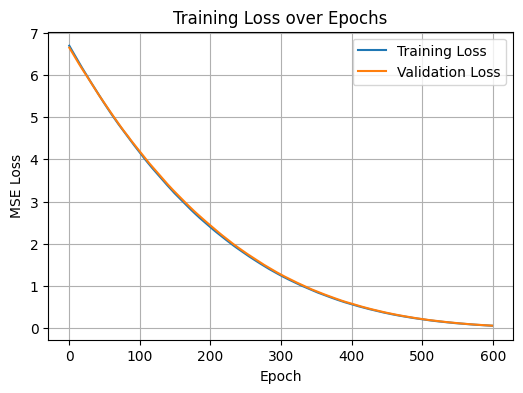

In [14]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
#plt.tight_layout()
plt.show()


In [15]:
p = np.polyfit(X, Y, 1)   # slope p[0], intercept p[1]
linear_fit = np.polyval(p, X)

# 10) Residuals
residual_dnn = Y - Yhat
residual_lin = Y - linear_fit

# 11) Plot
idx_sort = np.argsort(X)
sorted_X       = X[idx_sort]
sorted_Y       = Y[idx_sort]
sorted_Yhat    = Yhat[idx_sort]
sorted_lin     = linear_fit[idx_sort]
sorted_res_dnn = residual_dnn[idx_sort]

In [16]:
# === Plot 2: Residuals ===
rms_dnn = np.sqrt(np.mean(residual_dnn**2))
rms_lin = np.sqrt(np.mean(residual_lin**2))
print(f"RMS error - DNN   : {rms_dnn:.6f} µA")
print(f"RMS error - Linear: {rms_lin:.6f} µA")

RMS error - DNN   : 137.991089 µA
RMS error - Linear: 0.183910 µA


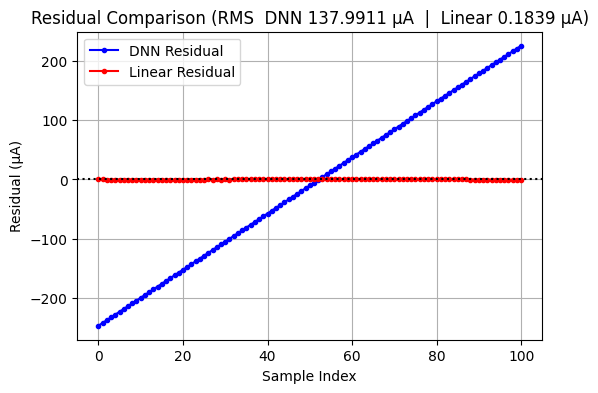

In [17]:
plt.figure(figsize=(6,4))
plt.plot(residual_dnn, "b.-", label="DNN Residual")
plt.plot(residual_lin, "r.-", label="Linear Residual")
plt.axhline(0, color="k", linestyle=":")
plt.title(f"Residual Comparison (RMS  DNN {rms_dnn:.4f} µA  |  Linear {rms_lin:.4f} µA)")
plt.xlabel("Sample Index")
plt.ylabel("Residual (µA)")
plt.legend(); plt.grid(True)

In [18]:
# DNN
W, b = model.get_weights()
print("DNN model: y = %.6f * x + %.6f" % (W[0][0], b[0]))
# Linear
p = np.polyfit(X, Y, 1)
print("Linear model: y = %.6f * x + %.6f" % (p[0], p[1]))

DNN model: y = 0.756310 * x + 0.018031
Linear model: y = 0.978159 * x + -8.113826


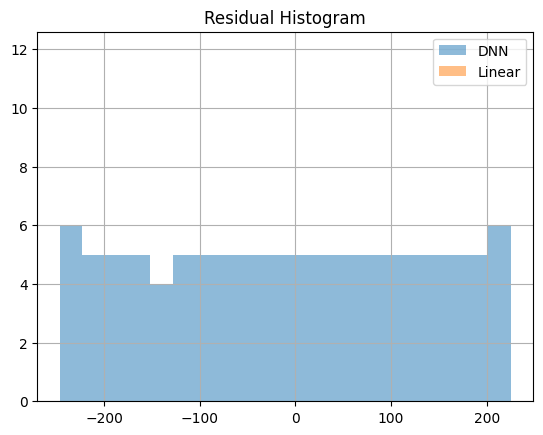

In [19]:
plt.hist(residual_dnn, bins=20, alpha=0.5, label='DNN')
plt.hist(residual_lin, bins=20, alpha=0.5, label='Linear')
plt.legend(); plt.title('Residual Histogram'); plt.grid(True)

In [20]:
print("Max error (DNN):", np.max(np.abs(residual_dnn)))
print("Max error (Linear):", np.max(np.abs(residual_lin)))

Max error (DNN): 246.18439
Max error (Linear): 0.6355591


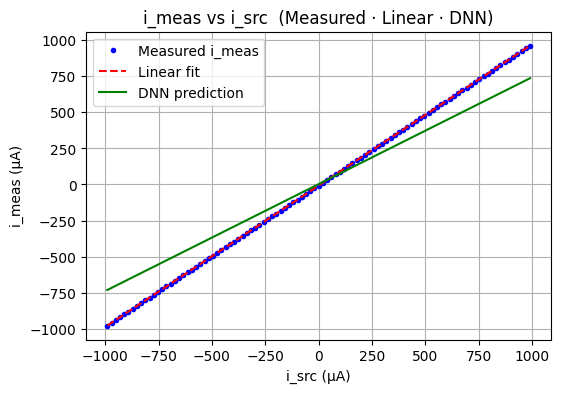

In [21]:
# === Plot 1: i_meas vs i_src ===
plt.figure(figsize=(6,4))
plt.plot(sorted_X, sorted_Y,     "b.", label="Measured i_meas")
plt.plot(sorted_X, sorted_lin,   "r--", label="Linear fit")
plt.plot(sorted_X, sorted_Yhat,  "g-", label="DNN prediction")
plt.xlabel("i_src (µA)")
plt.ylabel("i_meas (µA)")
plt.title("i_meas vs i_src  (Measured · Linear · DNN)")
plt.legend(); plt.grid(True)

→ RMS after DNN mean offset correction: 139.113571 µA


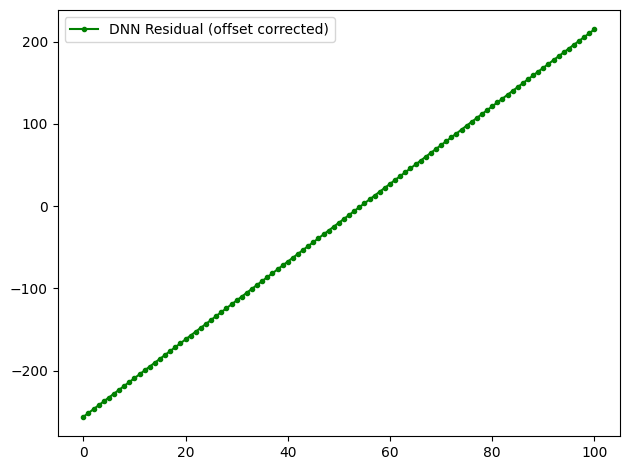

In [22]:
mean_res_dnn = residual_dnn.mean()
Yhat_corr = Yhat - mean_res_dnn
residual_dnn_corr = Y - Yhat_corr
rms_dnn_corr = np.sqrt(np.mean(residual_dnn_corr**2))
print(f"→ RMS after DNN mean offset correction: {rms_dnn_corr:.6f} µA")

plt.plot(residual_dnn_corr, "g.-", label="DNN Residual (offset corrected)")
plt.legend(); plt.tight_layout()
plt.show()

In [23]:
# save
model.save('adc_dnn_model.h5')

In [24]:
import hls4ml
from tensorflow import keras
import pprint, os

# keras model
model = keras.models.load_model('adc_dnn_model.h5', compile=False)

In [25]:
# 2) hls4ml config
config = hls4ml.utils.config_from_keras_model(model, granularity='name')

Interpreting Sequential
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: fc, layer type: Dense, input shapes: [[None, 1]], output shape: [None, 1]


In [28]:
from pprint import pprint
pprint(config['LayerName'].keys())

dict_keys(['input_2', 'fc', 'fc_linear'])


In [30]:
# Global model settings
config['Model']['Precision']   = 'ap_fixed<20,10>'  # Total 20 bits, 10 integer bits
config['Model']['ReuseFactor'] = 1
#config['Model']['ReuseFactor'] = 4  # or higher (e.g. 8, 16) if needed
config['Model']['Strategy']    = 'Latency'
#config['Model']['Strategy'] = 'Resource'

# Layer-specific precision
config['LayerName']['input_2']['Precision'] = 'ap_fixed<20,10>'

config['LayerName']['fc']['Precision'] = {
    'weight': 'ap_fixed<20,10>',     # Weights: 8 bits, 2 integer bits
    'bias':   'ap_fixed<20,10>',     # Bias:    8 bits, 2 integer bits
    'result': 'ap_fixed<20,10>'    # Output from FC layer: 20 bits
}

In [31]:
hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=config,
    output_dir='hls4ml_adc_dnn_pynq',
    part='xc7z020clg400-1',  # PYNQ-Z2 Zynq-7020
    backend='VivadoAccelerator'    #Vivado HLS
)

Interpreting Sequential
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: fc, layer type: Dense, input shapes: [[None, 1]], output shape: [None, 1]
Creating HLS model


In [32]:
hls_model.compile()

Writing HLS project
Done


In [33]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
import os

os.environ['XILINX_VIVADO'] = '/tools/Xilinx/Vivado/2019.2'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

In [34]:
#build with Vivado HLS 2019.2
import hls4ml
hls_model.build(csim=False, synth=True, export=True, bitfile=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'diag' on host 'WPS-175354' (Linux_x86_64 version 6.8.0-59-generic) on Thu Jul 10 16:44:48 EDT 2025
INFO: [HLS 200-10] On os Ubuntu 22.04.5 LTS
INFO: [HLS 200-10] In directory '/home/diag/Downloads/kiman_DNN/hls4ml_adc_dnn_pynq'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/diag/Downloads/kiman_DNN/hls4ml_adc_dnn_pynq/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.cpp' to the project
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HL

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.367',
  'BestLatency': '24',
  'WorstLatency': '24',
  'IntervalMin': '8',
  'IntervalMax': '8',
  'BRAM_18K': '0',
  'DSP': '1',
  'FF': '1807',
  'LUT': '1829',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'},
 'TimingReport': {'WNS': 1.075,
  'TNS': 0.0,
  'WHS': 0.029,
  'THS': 0.0,
  'WPWS': 3.75,
  'TPWS': 0.0}}

In [43]:
import os
os.system("source /tools/Xilinx/Vivado/2019.2/settings64.sh")

sh: 1: source: not found


32512

Writing HLS project
Done
RMS error (HLS model): 138.181130 µA


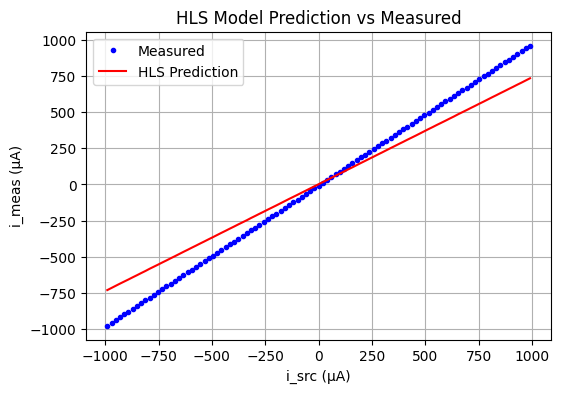

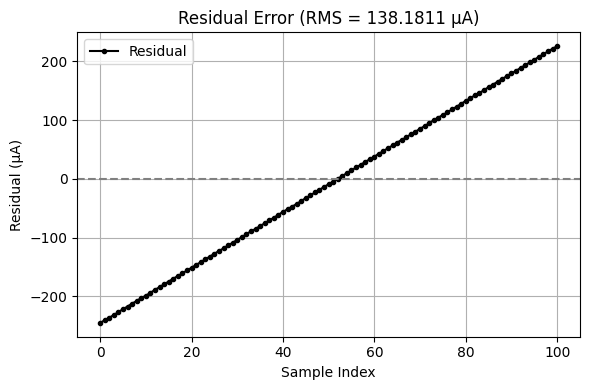

In [39]:
# Verification test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# (1) Load CSV file
df = pd.read_csv("samples_A_101p_uA.csv", comment='#', header=None,
                 names=['i_src', 'range_idx', 'i_meas', 'adc_val'])

# (2) Select data for Range 1
range_id = 1
sub = df[df.range_idx == range_id]
X = sub.i_src.to_numpy()
Y = sub.i_meas.to_numpy()

# (3) Normalize input and target (z-score)
muX, sigX = np.mean(X), np.std(X)
muY, sigY = np.mean(Y), np.std(Y)
Xn = (X - muX) / sigX
Yn = (Y - muY) / sigY

# (4) Prepare input for HLS C model (float32, 2D shape)
x_test = Xn.astype(np.float32).reshape(-1, 1)

# (5) Compile and run HLS model prediction
hls_model.compile()  # load .so file
y_pred = hls_model.predict(x_test)

# (6) Denormalize the prediction
y_pred = y_pred.flatten()
Yhat = y_pred * sigY + muY

# (7) Compute residuals
residual = Y - Yhat
rms = np.sqrt(np.mean(residual ** 2))
print(f"RMS error (HLS model): {rms:.6f} µA")

# (8) Plot: Measured vs Predicted
plt.figure(figsize=(6, 4))
plt.plot(X, Y, 'b.', label='Measured')
plt.plot(X, Yhat, 'r-', label='HLS Prediction')
plt.xlabel('i_src (µA)')
plt.ylabel('i_meas (µA)')
plt.title('HLS Model Prediction vs Measured')
plt.grid(True)
plt.legend()

# (9) Plot: Residuals
plt.figure(figsize=(6, 4))
plt.plot(residual, 'k.-', label='Residual')
plt.axhline(0, color='gray', linestyle='--')
plt.title(f'Residual Error (RMS = {rms:.4f} µA)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (µA)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


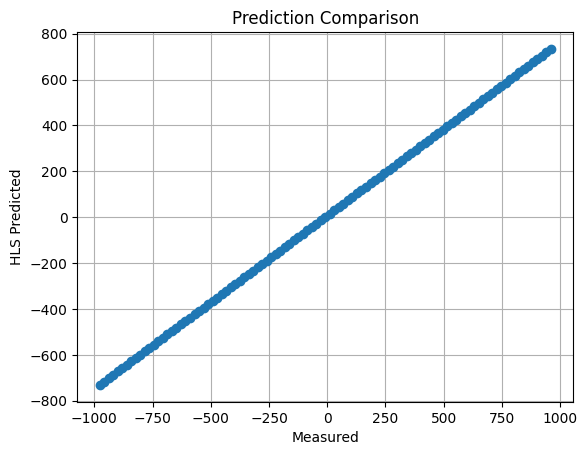

In [40]:
plt.plot(Y, Yhat, 'o'); plt.xlabel("Measured"); plt.ylabel("HLS Predicted"); plt.title("Prediction Comparison")
plt.grid(True)


1/1 [==============================] - 0s 31ms/step
Writing HLS project
Done


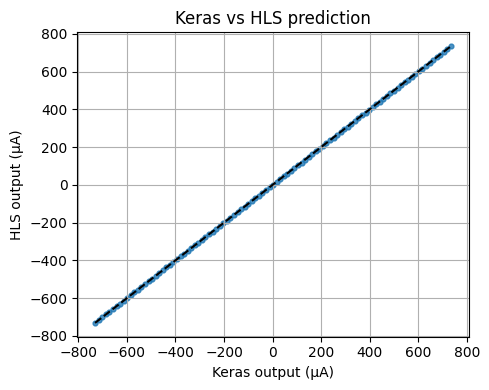

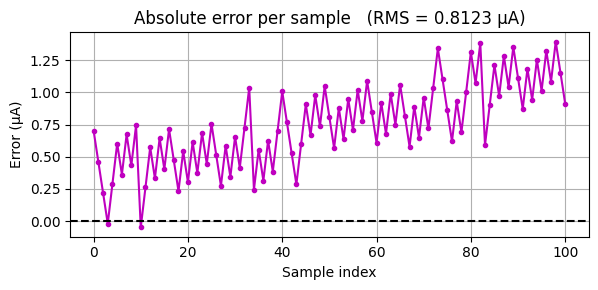

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# --- (re)build the normalised test input ----------------------------------
x_test = ((X - muX) / sigX).astype(np.float32).reshape(-1, 1)

# --- Keras FP32 reference --------------------------------------------------
y_keras_norm = model.predict(x_test, batch_size=256).flatten()
y_keras      = y_keras_norm * sigY + muY          # de-normalise

# --- HLS fixed-point model -------------------------------------------------
hls_model.compile()                               # loads the C-sim .so
y_hls_norm = hls_model.predict(x_test).flatten()
y_hls      = y_hls_norm * sigY + muY              # de-normalise

# --- Scatter plot: Keras vs HLS -------------------------------------------
plt.figure(figsize=(5, 4))
plt.scatter(y_keras, y_hls, s=12, alpha=0.8)
_min, _max = min(y_keras.min(), y_hls.min()), max(y_keras.max(), y_hls.max())
plt.plot([_min, _max], [_min, _max], 'k--')       # y = x reference
plt.xlabel("Keras output (µA)")
plt.ylabel("HLS output (µA)")
plt.title("Keras vs HLS prediction")
plt.grid(True)
plt.tight_layout()

# --- Error plot -----------------------------------------------------------
abs_err = y_keras - y_hls
rms_err = np.sqrt(np.mean(abs_err**2))

plt.figure(figsize=(6, 3))
plt.plot(abs_err, 'm.-')
plt.axhline(0, color='k', ls='--')
plt.title(f'Absolute error per sample   (RMS = {rms_err:.4f} µA)')
plt.xlabel("Sample index")
plt.ylabel("Error (µA)")
plt.grid(True)
plt.tight_layout()
plt.show()
